# Trabalho Final

**Aluno:** Franklin Alves de Oliveira <br>
**Profa.:** Asla Sá.

<br>

Nesse notebook serão apresentadas as visualizações criadas para o Trabalho Final da disciplina de Visualização de Dados da EMAp-FGV.

----

## Ideia inicial

A ideia inicial consistia em fazer um gráfico "*gapminder-like*" para visualizar um possível padrão entre as taxas de casamento e divórcio em mais de 40 países.

Abaixo, segue uma animação do *gapminder* original. Nesse gráfico, é possível visualizar uma forte tendência temporal de redução da taxa de natalidade e aumento da expectativa de vida. 

![](gapminder.gif)

**Hipótese:** o senso comum aponta que o número de casamentos vem diminuindo ao longo do tempo. Dada essa informação, podemos destacar duas possibilidades:

    - A diminuição do número de casamentos ocasiona em menos divórcios em um tempo posterior. 
    - O aumento na taxa de divórcios ocasiona em menos casamentos em anos subsequentes.

Nesses dois cenários, o formato de gráfico **gapminder-like** possibilitaria a visualização desse padrão, com a diferença de que os pontos caminhariam em direção à origem, com o passar do tempo.

-----

Como de praxe, vamos começar com alguns imports...

In [1]:
import numpy as np
import pandas as pd
import altair as alt

import seaborn as sns
import matplotlib.pyplot as plt

# biblioteca para coletar os nomes dos continentes
import pycountry_convert as pc

# ativando renderizador do notebook
alt.renderers.enable('notebook');

## Motivação para a escolha do tema

O número de casamentos nos EUA vem decrescendo bastante ao longo do tempo...

O gráfico abaixo é uma replicação [deste gráfico](https://www.statista.com/statistics/195951/marriage-rate-in-the-united-states-since-1990/), que  mostra a evolução da taxa de casamentos (nº de casamentos a cada 1000 habitantes) nos Estados Unidos. 

In [2]:
usa_marriage_rate = pd.read_csv('./data/usa_marriage_rate.csv', encoding='utf-8', index_col=0)

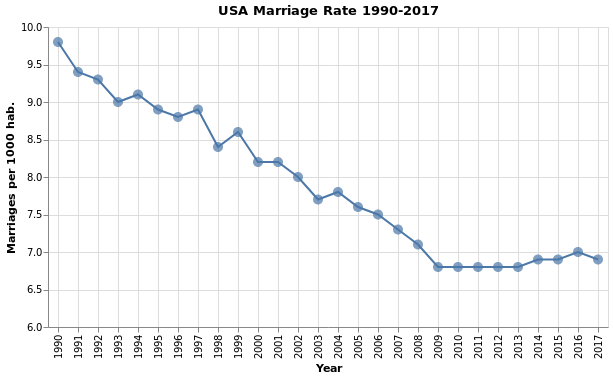

In [3]:
line = alt.Chart(data= usa_marriage_rate, title='USA Marriage Rate 1990-2017'
    ).mark_line(filled=False).encode(
    x= alt.X('year', type='nominal', title='Year', axis=alt.Axis(grid=True)),
    y= alt.Y('rate', scale= alt.Scale(domain=[6, 10]), title='Marriages per 1000 hab.')
)

points = alt.Chart(data= usa_marriage_rate).mark_point(filled=True, size=100).encode(
    x= alt.X('year', type='nominal', title='Year', axis=alt.Axis(grid=True)),
    y= alt.Y('rate', scale= alt.Scale(domain=[6, 10]), title='Marriages per 1000 hab.'),
    tooltip=alt.Tooltip(['rate', 'year'])
)

# salvando gráfico
# (line + points).save('./viz/usa_marriage_rage.svg')
# (line + points).save('./viz/usa_marriage_rage.html')

# exibindo na tela
line + points

<font color='red'>**OBS:**</font> Note que o eixo $y$ **NÃO** começa em $0$.

<br>

### Representação gráfica que vamos usar:

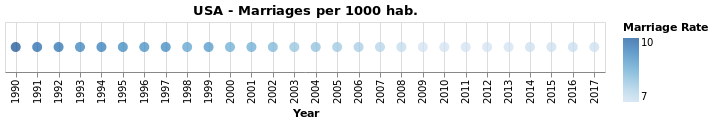

In [4]:
points = alt.Chart(data= usa_marriage_rate, width=600, height=50, title='USA - Marriages per 1000 hab.'
        ).mark_point(filled=True, size=100).encode(
    x= alt.X('year', type='nominal', title='Year', axis=alt.Axis(grid=True)),
    tooltip=alt.Tooltip(['rate', 'year']),
    color=alt.Color('rate', title='Marriage Rate')
)

# salvando gráfico
# points.save('./viz/representacao_grafica.html')
# points.save('./viz/representacao_grafica.svg')

points

## Importando os datasets

Agora, vamos importar o dataset com as taxas de casamento e divórcio.  

In [5]:
excel = pd.ExcelFile('./data/SF_3_1_Marriage_divorce_rates.xlsx')
mar = pd.read_csv('./data/marriages.csv', sep=',', encoding='utf-8-sig', index_col=0)
div = pd.read_csv('./data/divorces.csv', sep=',', encoding='utf-8-sig', index_col=0)
age = pd.read_csv('./data/mean_age_first_marriage.csv', sep=',', encoding='utf-8-sig', index_col=0)

<br>

### Definições:

$$Taxa~de~casamentos = \frac{Nº~de~casamentos}{1000~hab.} $$

<br>

$$Taxa~de~divórcios = \frac{Nº~de~divórcios}{1000~hab.} $$

## Preparativos...

Antes de chegarmos nas visualizações, vamos preparar alguns dataframes auxiliares.

### Ordenando os dataframes

In [6]:
# ordenando os valores 
mar.sort_values(['Continent','Country','Year'], inplace=True)
div.sort_values(['Continent','Country','Year'], inplace=True)
age.sort_values(['Continent','Country','Year'], inplace=True)

In [7]:
# dataframes para criar as legendas
mar1 = pd.DataFrame(mar.groupby(['Continent', 'Country']).count()['Year']).reset_index()
mar1 = pd.DataFrame(mar1.groupby('Continent').count()['Country']).reset_index()
mar1['Number of Registers'] = pd.DataFrame(mar.groupby(['Continent']).count()['Year']).reset_index()['Year']
mar1.rename(columns={'Country':'Number of Countries'}, inplace=True)
mar1['c'] = 1

div1 = pd.DataFrame(div.groupby(['Continent', 'Country']).count()['Year']).reset_index()
div1 = pd.DataFrame(div1.groupby('Continent').count()['Country']).reset_index()
div1['Number of Registers'] = pd.DataFrame(mar.groupby(['Continent']).count()['Year']).reset_index()['Year']
div1.rename(columns={'Country':'Number of Countries'}, inplace=True)
div['c'] = 1  # coluna para criar a legenda

In [8]:
# criando dataframe de zeros e NA para background (casamentos)
country = np.repeat(mar['Country'].unique(), 58)
years = np.repeat(list(range(1960, 2018)), 45)
temp = pd.DataFrame([country, years]).transpose()

df = pd.DataFrame([np.zeros(45*58),np.zeros(45*58),np.zeros(45*58)]).transpose()
counter = 0
for country in mar['Country'].unique():
    cont = mar[mar['Country']==country]['Continent'].unique()[0]
    for year in range(1960, 2018):
        df.iloc[counter, 0] = country
        df.iloc[counter, 1] = year
        df.iloc[counter, 2] = cont
        counter += 1

df['marriage_rate'] = 'NA'
df['NA'] = 0.
df.columns = ['Country', 'Year', 'Continent', 'marriage_rate', 'NA']


# criando dataframe de zeros e NA para background (divórcios)
country = np.repeat(div['Country'].unique(), 58)
years = np.repeat(list(range(1960, 2018)), 45)
temp = pd.DataFrame([country, years]).transpose()

df1 = pd.DataFrame([np.zeros(45*58),np.zeros(45*58),np.zeros(45*58)]).transpose()
counter = 0
for country in mar['Country'].unique():
    cont = mar[mar['Country']==country]['Continent'].unique()[0]
    for year in range(1960, 2018):
        df1.iloc[counter, 0] = country
        df1.iloc[counter, 1] = year
        df1.iloc[counter, 2] = cont
        counter += 1

df1['marriage_rate'] = 'NA'
df1['NA'] = 0.
df1.columns = ['Country', 'Year', 'Continent', 'marriage_rate', 'NA']

<br>

## Agora, vamos às visualizações.

-----

### Proposta: Gráfico gapminder-like

Abaixo, vamos exibir o gráfico inspirado no *gapminder*, apresentado por Hans Rosling em seu famoso [TED Talk](https://www.youtube.com/watch?v=hVimVzgtD6w&t=3s) em 2007

In [9]:
gap = pd.merge(mar, div, on=['Country', 'Year', 'Continent'])
gap = pd.merge(gap, age, on=['Country', 'Year', 'Continent'])

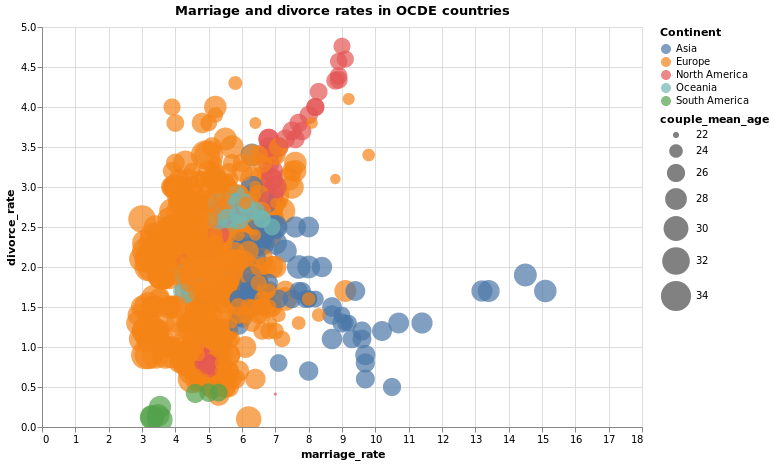

In [10]:
# gráfico com slider ("dinâmico")
slider = alt.binding_range(min=1990, max=2017, step=1, name='Year:')

selector = alt.selection_single(name="SelectorName", fields=['Year'],
                                bind=slider, empty= 'all')

gapminder_like = alt.Chart(gap, title='Marriage and divorce rates in OCDE countries').mark_point(filled=True).encode(
    x= alt.X('marriage_rate', scale= alt.Scale(domain=[0, 18])),
    y= alt.Y('divorce_rate', scale= alt.Scale(domain=[0, 5])),
    size= alt.Size('couple_mean_age', scale= alt.Scale(range=[10, 1000], zero=False)),
    color= alt.Color('Continent', type='nominal'),
    tooltip= alt.Tooltip(['Country', 'Continent', 'Year','marriage_rate','divorce_rate',
                          'couple_mean_age']),
    order= alt.Order('couple_mean_age', sort='descending')
).properties(
    width=600,
    height=400
).add_selection(
    selector
).transform_filter(
    selector
).interactive()

# salvando o gráfico
# gapminder_like.save('./viz/gapminder_like.svg')
# gapminder_like.save('./viz/gapminder_like.html')

gapminder_like

Como povemos ver nesse gráfico, há uma tendência temporal nos números de casamentos e divórcios, mas não é tão apelativa visualmente. O que podemos destacar é que, com o passar do tempo, há uma maior concentração dos países em taxas de casamento e divórcio parecidas.

Mas não vamos parar por aqui... Esse dataset ainda tem muitas informações a serem exploradas. Vamos seguir em frente e buscar valiosos *insights* com novas visualizações.

<br>

### Gráfico 1: Something borrowed, something...

In [11]:
selection = alt.selection_multi(fields=['Continent'])

# definindo gráfico de background
back = alt.Chart(data= df, width=620, height=500, title='Marriages per 1000 hab.'
        ).mark_rect(filled=True, color='#ffffff').encode(
    x= alt.X('Year', type='nominal', title='Year', axis=None),
    y = alt.Y('Country', type='nominal', title=None, axis=None,
             sort = ['Asia', 'Europe','North America','Oceania', 'South America']),
    tooltip = alt.Tooltip(['Country', 'Continent','Year', 'marriage_rate'])
)

legenda_cont = alt.Chart(data=mar1, width=15, title='Continent').mark_bar().encode(
    x=alt.X('c:N', axis=None),
    y=alt.Y('Continent', title=None, axis=alt.Axis(grid=False)),
    tooltip=alt.Tooltip(['Continent','Number of Countries', 'Number of Registers']),
    color= alt.condition(selection,alt.value('#408ec4'), alt.value('lightgrey'))
).add_selection(
    selection
)

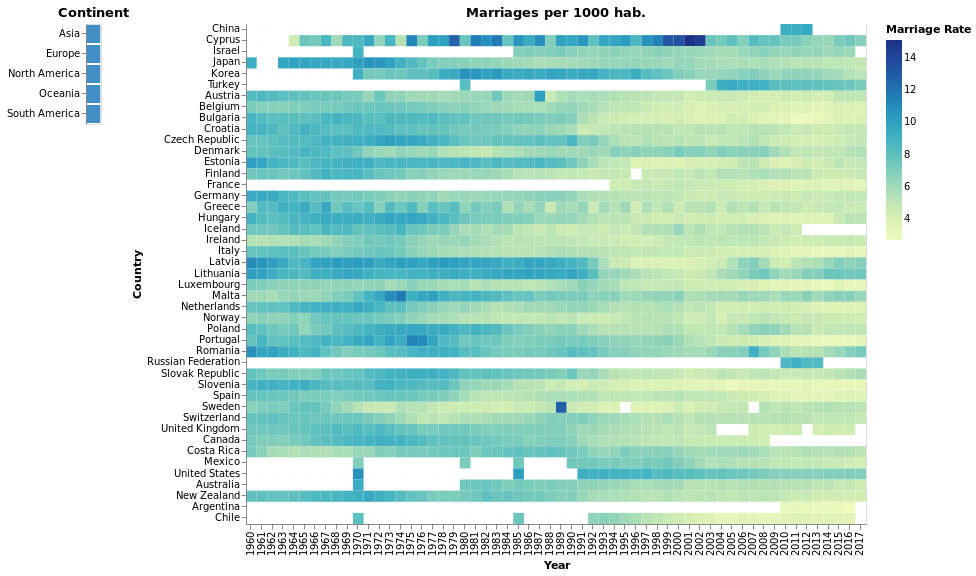

In [12]:
# gráfico das taxas de casamento
points = alt.Chart(data= mar, width=620, height=500, title='Marriages per 1000 hab.'
        ).mark_rect(filled=True).encode(
    x= alt.X('Year', type='nominal', title='Year', axis=alt.Axis(grid=True)),
    y = alt.Y('Country', type='nominal', title='Country', axis=alt.Axis(grid=True),
    sort = ['Asia', 'Europe','North America','Oceania', 'South America']),
    tooltip=alt.Tooltip(['Country','Continent','Year', 'marriage_rate']),
    color=alt.condition(selection,
    alt.Color('marriage_rate:Q', title='Marriage Rate', scale=alt.Scale(scheme='yellowgreenblue'),
             legend=alt.Legend(direction='vertical',orient='right', legendY=30)),
    alt.value('lightgray'))
).add_selection(
    selection
)

chart = alt.hconcat(legenda_cont, alt.layer(back, points).resolve_scale(y='independent'), 
            spacing=0).resolve_legend()

# chart.save('./viz/marriages.svg')
# chart.save('./viz/marriages.html')

chart

<br>

### Gráfico 2: Agora e para... sempre?

In [13]:
len(mar['Country'].unique())

45

In [14]:
selection1 = alt.selection(type='multi',fields=['Continent'])

# definindo gráfico de background
back1 = alt.Chart(data= df1, width=620, height=500, title='Divorces per 1000 hab.'
        ).mark_rect(filled=True, color='#ffffff').encode(
    x= alt.X('Year', type='nominal', title='Year', axis=None),
    y = alt.Y('Country', type='nominal', title=None, axis=None,
             sort = ['Asia', 'Europe','North America','Oceania', 'South America']),
    tooltip = alt.Tooltip(['Country', 'Continent','Year', 'marriage_rate'])
)


legenda_cont1 = alt.Chart(data=div1, width=15, title='Continent').mark_bar().encode(
    x=alt.X('c:N', axis=None),
    y=alt.Y('Continent', title=None, axis=alt.Axis(grid=False)),
    tooltip=alt.Tooltip(['Continent','Number of Countries', 'Number of Registers']),
    color= alt.condition(selection1,alt.value('#c57449'), alt.value('lightgrey'))
).add_selection(
    selection1
)

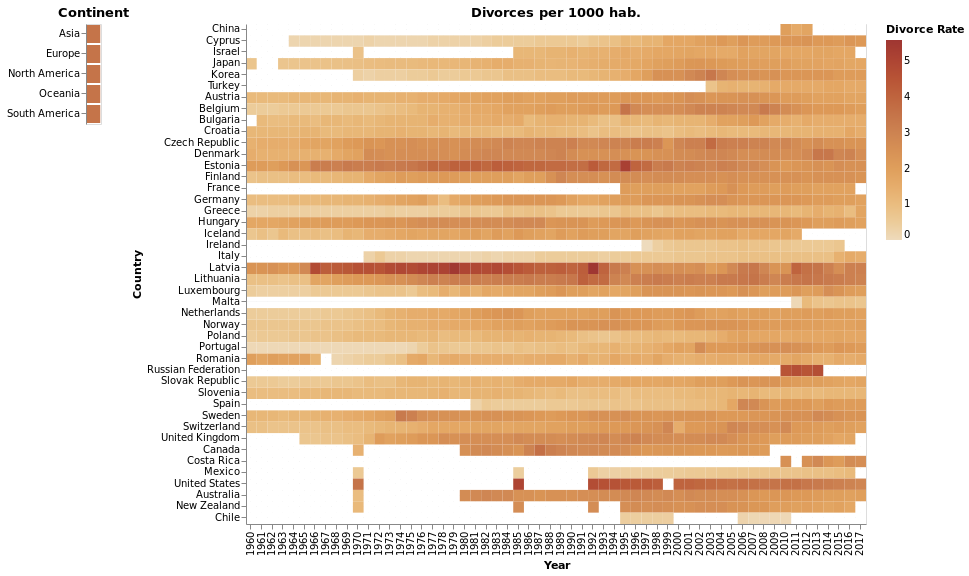

In [15]:
# Número de divórcios
points1 = alt.Chart(data= div, width=620, height=500, title='Divorces per 1000 hab.'
        ).mark_rect(filled=True).encode(
    x= alt.X('Year', type='nominal', title='Year', axis=alt.Axis(grid=True)),
    y = alt.Y('Country', type='nominal', title='Country', axis=alt.Axis(grid=True),
    sort = ['Asia', 'Europe','North America','Oceania', 'South America']),
    tooltip=alt.Tooltip(['Country','Continent','Year','divorce_rate']),
    color=alt.condition(selection1,
    alt.Color('divorce_rate:Q', title='Divorce Rate', scale=alt.Scale(scheme='browns')),
    alt.value('lightgrey'))
).add_selection(selection1)

chart1 = alt.hconcat(legenda_cont1,alt.layer(back1, points1).resolve_scale(y='independent'), spacing=0)

# salvando o gráfico
# chart1.save('./viz/divorces.svg')
# chart1.save('./viz/divorces.html')

chart1

### Gráfico 3: Em média, casais estão casando mais tarde...

In [191]:
# criando um background
g0 = alt.Chart(data= age, width=620, height=500, title='Mean age at first marriage'
        ).mark_point(filled=True, size=100, color='#f1f1f1').encode(
    x= alt.X('male_mean_age', type='quantitative', scale=alt.Scale(domain=[18,38]),
             axis=alt.Axis(grid=True), title='mean age'),
    y = alt.Y('Country', type='nominal',  axis=None,
    sort = ['Asia', 'Europe','North America','Oceania', 'South America']),
    tooltip=alt.Tooltip(['Country', 'Year', 'male_mean_age'])
)
g1 = alt.Chart(data= age, width=620, height=500, title='Mean age at first marriage'
        ).mark_point(filled=True, size=100, color='#f1f1f1').encode(
    x= alt.X('female_mean_age', type='quantitative', axis=None),
    y = alt.Y('Country', type='nominal', axis=alt.Axis(grid=True),
    sort = ['Asia', 'Europe','North America','Oceania', 'South America']),
    tooltip=alt.Tooltip(['Country', 'Year', 'female_mean_age'])
)

background = g0+g1

In [192]:
### dataframes para legenda
legend = pd.DataFrame([['Male','Female'],[1,1]], index=['Sex','c']).transpose()
continente =  pd.DataFrame([['Asia','Europe', 'South America', 
                    'North America', 'Oceania'],[1,1,1,1,1]], index=['Continent','c']).transpose()

# conta número de países
temp = pd.DataFrame(age.groupby(['Country','Continent']).count().reset_index().groupby('Continent'
    ).count().reset_index())[['Continent', 'Country']].rename(columns={'Country':'Number of Countries'})

# conta número de registros
temp1 = pd.DataFrame(age.groupby(['Continent']).count()).reset_index()[['Continent','Year']]
temp1.rename(columns={'Year':'Number of registers'}, inplace=True)

# atualiza legenda
continente = pd.merge(continente,temp, on='Continent')
continente = pd.merge(continente, temp1, on='Continent')


### definindo seletores
select_sex = alt.selection_multi(fields=['Sex'], name='seletor_sexo_masculino')
select_sex1 = alt.selection_multi(fields=['Sex'], name='seletor_sexo_feminino')
select_continent = alt.selection_multi(fields=['Continent'], name='Seletor_continente')


# legenda seletora
lgd_a = alt.Chart(data=legend[legend['Sex']=='Male'], width=15, height=30, title='Gender').mark_rect().encode(
    y=alt.Y('Sex:N', title=None),
    x=alt.X('c:N', axis=None),
    color= alt.condition(select_sex, alt.value('#66b5c3'), alt.value('lightgrey'))
).add_selection(select_sex)

lgd_b = alt.Chart(data=legend[legend['Sex']=='Female'], width=15, height=30).mark_rect().encode(
    y=alt.Y('Sex:N', title=None),
    x=alt.X('c:N', axis=None),
    color= alt.condition(select_sex1,alt.value('#f571a5'),alt.value('lightgrey'))
).add_selection(select_sex1)


# legenda do Gênero
lgd = alt.vconcat(lgd_a, lgd_b, spacing=0)

# legenda do Continente
cont = alt.Chart(data = continente, width=15, height=5*30, title='Continent').mark_rect().encode(
    x = alt.X('c:Q', axis=None),
    y = alt.Y('Continent:N', title=None),
    color= alt.condition(select_continent, alt.Color('c:N',scale=alt.Scale(scheme='blues'), legend=None),
                         alt.value('lightgrey')),
    tooltip=alt.Tooltip(['Continent','Number of Countries','Number of registers'])
).add_selection(select_continent)

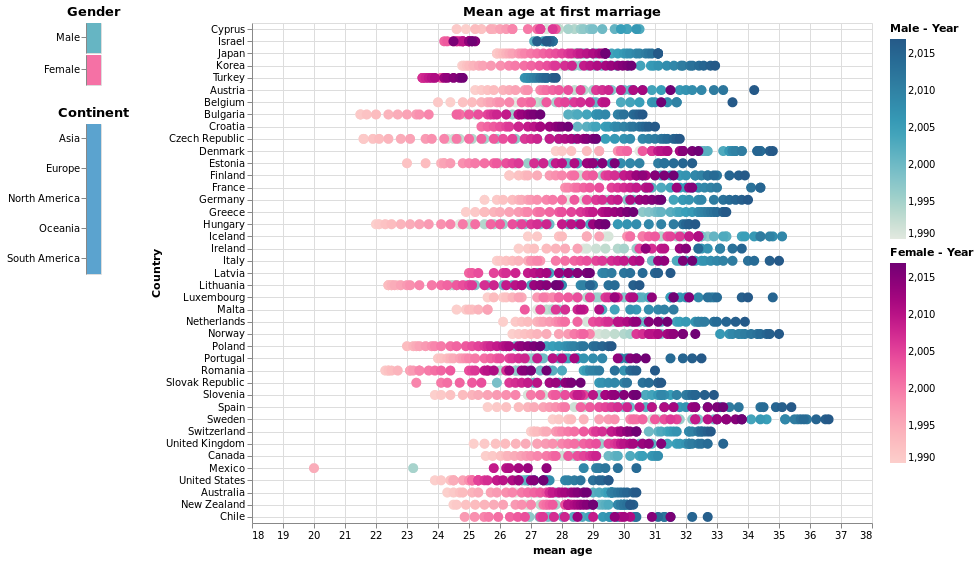

In [193]:
# definindo gráficos
points0 = alt.Chart(data= age, width=620, height=500, title='Mean age at first marriage'
        ).mark_point(filled=True, size=100).encode(
    x= alt.X('male_mean_age', type='quantitative', title='Mean Age',scale=alt.Scale(domain=[18,38]),
             axis=None),
    y = alt.Y('Country', type='nominal', title='Country', axis=None,
    sort = ['Asia', 'Europe','North America','Oceania', 'South America']),
    tooltip=alt.Tooltip(['Country', 'Continent','Year', 'male_mean_age']),
    color=alt.Color('Year:Q', title='Male - Year', scale=alt.Scale(scheme='lighttealblue')),
    opacity = alt.condition(select_continent, alt.value(1), alt.value(0))
);

points1 = alt.Chart(data= age, width=620, height=500, title='Mean age at first marriage'
        ).mark_point(filled=True, size=100).encode(
    x= alt.X('female_mean_age', type='quantitative', title='Mean Age',scale=alt.Scale(domain=[18,38]), 
             axis=None),
    y = alt.Y('Country', type='nominal', title='Country', axis=None,
    sort = ['Asia', 'Europe','North America','Oceania', 'South America']),
    tooltip=alt.Tooltip(['Country', 'Continent','Year', 'female_mean_age']),
    color= alt.Color('Year:Q', title='Female - Year', scale=alt.Scale(scheme='redpurple')),
    opacity = alt.condition(select_continent, alt.value(1), alt.value(0)),
);

# juntando os gráficos com escala de cor independente
chart2 = alt.hconcat( alt.vconcat(lgd, cont), #legenda
    alt.layer(
        background,
        points0.add_selection(select_continent, select_sex1).transform_filter(select_sex1),
        points1.add_selection(select_sex).transform_filter(select_sex)
    ).resolve_scale(color='independent', y='independent') 
)

# salvando o gráfico
# chart2.save('./viz/mean_age.svg')
# chart2.save('./viz/mean_age.html')

chart2

### Gráfico 3 (modificado): animado à la Hans Rosling

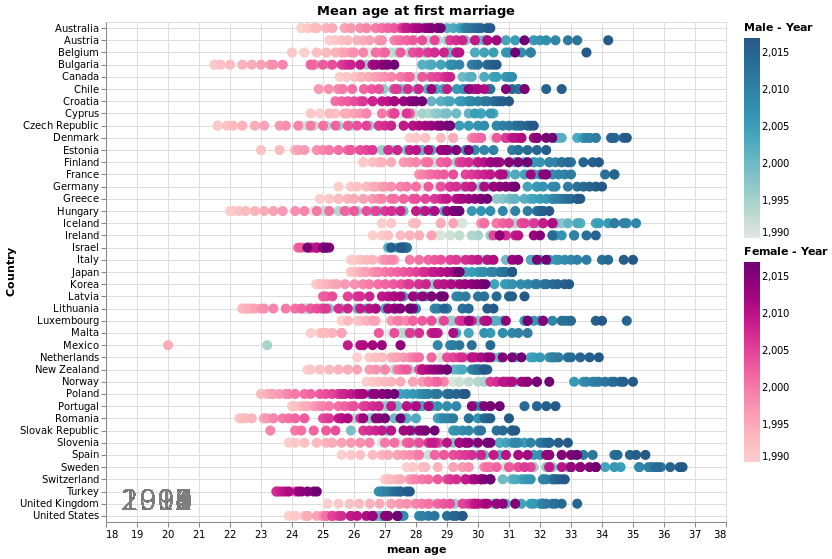

In [194]:
# gráfico com slider ("dinâmico")
slider = alt.binding_range(min=1990, max=2017, step=1, name='Year:')
seletor_ano = alt.selection_single(name="Seletor_ano", fields=['Year'],
                                bind=slider, empty='all')

# adicionando seletor (slider)
points0 = points0.encode(opacity=alt.value(1)).add_selection(
    seletor_ano
).transform_filter(
    seletor_ano
)

points1 = points1.encode(opacity=alt.value(1)).transform_filter(
    seletor_ano
)

# criando marca d'água
watermark = alt.Chart(age).mark_text(
        align='left', fontSize=28, fontWeight=100, opacity=0.5, x=15, y=480, color='grey'
).encode(
    opacity=alt.value(0.5),
    text = alt.Text('Year')
).transform_filter(
    seletor_ano
)

chart3 = alt.layer(
    background,
    watermark,
    points0,
    points1
).resolve_scale(color='independent')

# salvando o gráfico
# chart3.save('./viz/mean_age_animated.svg')
# chart3.save('./viz/mean_age_animated.html')

chart3

<font color='blue' size=5>Referências Teóricas:</font>

- Andy Kirk, [Data Visualization](https://www.amazon.com.br/DATA-VISUALISATION-Andy-Kirk/dp/1473912148)
- Jacques Bertin, [Semiology of Graphics](https://www.amazon.com.br/Semiology-Graphics-Diagrams-Networks-Maps/dp/1589482611)

<font color='darkgreen' size=5>Referências Práticas (visualizações prontas):</font>

- Hans Rosling, [TED Talk](https://www.youtube.com/watch?v=hVimVzgtD6w&t=3s)
- WSJ, [Effectiveness of Vaccines](https://flowingdata.com/2015/02/19/impact-of-vaccines-throughout-history/)

**Fim!**